# Mounting the drive to connect the google drive with colab to save data from vanishing once the browser is closed.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = '/content/drive/MyDrive/KaggleDatasets/Cucumber Leaf disease dataset/cucumber_Leaf_Disease'

# The following codes were used as I faced a problem while running the cells again. Error was torch library was not found . For this I uninstalled torch and reinstalled it.

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio


# Importing necessary libraries

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.models as models
import torch.nn as nn
import matplotlib.pyplot as plt
import os


# Transforming , converting to tensor & normalizing the pixel values of images. This is done for reducing computational complexity.  

In [5]:
transform = transforms.Compose([
    transforms.Resize((224,224)),  #Changes the dimensions of images to 224*224 as most of the predefined models(eg.,ResNet) have this requirement
    transforms.ToTensor(),         #converts the 0 to 255 pixel value range to 0 to 1
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])   #Normalizes the pixel values having a mean of 0.5 (1st tuple ){0.5 is present 3 times for R,G,B channels} and std deviation of 0.5
    ])

# Load datasets
train_dataset= datasets.ImageFolder(root=f'{dataset_path}/train', transform=transform)
test_dataset= datasets.ImageFolder(root=f'{dataset_path}/test', transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)   #shuffle is made false here because We don't want to shuffle the test data

# Verify Dataset & Classes

In [6]:
#Classes in the dataset
print(train_dataset.classes)
#number of samples in train and test sets
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

['Downy_mildew', 'Healthy_leaves', 'Powdery_mildew']
Train samples: 3713
Test samples: 51


# Creating the Model and it's architecture

In [7]:
from torchvision.models import resnet18, ResNet18_Weights
weights = ResNet18_Weights.DEFAULT    # Automatically picks the latest pretrained weights
model = resnet18(weights=weights)

model.fc = torch.nn.Linear(model.fc.in_features, 3)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 78.8MB/s]


# Adding Softmax function to output

In [8]:
# Example output from model
output=torch.tensor([[2.0,1.0,0.1]])
#applying softmax
softmax = torch.nn.Softmax(dim=1)
probabilities = softmax(output)
print(probabilities)  #probabilities for each class

tensor([[0.6590, 0.2424, 0.0986]])


# Training the Model in batches and no . of epoch is taken 10

In [9]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # Import tqdm for progress bar

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # 10 epochs
    model.train()
    running_loss = 0.0
    # Wrap train_loader with tqdm for a progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{10}", unit="batch")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass for linear operation on dataset for prediction without optimization
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass for optimizing weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}, Average Loss: {running_loss/len(train_loader)}")


Epoch 1/10: 100%|██████████| 117/117 [26:32<00:00, 13.61s/batch, loss=0.996]


Epoch 1, Average Loss: 0.12923336113055842


Epoch 2/10: 100%|██████████| 117/117 [16:59<00:00,  8.71s/batch, loss=2.42]


Epoch 2, Average Loss: 0.0914241369210709


Epoch 3/10: 100%|██████████| 117/117 [16:45<00:00,  8.59s/batch, loss=6.18]


Epoch 3, Average Loss: 0.10704890647495134


Epoch 4/10: 100%|██████████| 117/117 [16:44<00:00,  8.58s/batch, loss=3.59]


Epoch 4, Average Loss: 0.06501768339842232


Epoch 5/10: 100%|██████████| 117/117 [16:45<00:00,  8.59s/batch, loss=0.00626]


Epoch 5, Average Loss: 0.027111200974462155


Epoch 6/10: 100%|██████████| 117/117 [16:43<00:00,  8.58s/batch, loss=0.00751]


Epoch 6, Average Loss: 0.015093560525776846


Epoch 7/10: 100%|██████████| 117/117 [16:47<00:00,  8.61s/batch, loss=5.63]


Epoch 7, Average Loss: 0.0692750595658137


Epoch 8/10: 100%|██████████| 117/117 [16:41<00:00,  8.56s/batch, loss=0.261]


Epoch 8, Average Loss: 0.06522749165574518


Epoch 9/10: 100%|██████████| 117/117 [16:40<00:00,  8.55s/batch, loss=5.88]


Epoch 9, Average Loss: 0.07695039798247899


Epoch 10/10: 100%|██████████| 117/117 [16:32<00:00,  8.48s/batch, loss=3.68]

Epoch 10, Average Loss: 0.047691369754099086


# Saving the model's learned weights in .pth format for easy deployment and portability

In [11]:
# Saving the model's state_dict(i.e., weights/parameters)
torch.save(model.state_dict(), 'resnet18_CucumberLeaf.pth')


In [13]:
torch.save(model.state_dict(),'/content/drive/MyDrive/KaggleDatasets/Cucumber Leaf disease dataset/resnet18_CucumberLeaf.pth')

## Evaluating The Accuracy

In [12]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 98.04%


# Confusion Matrix(Leaf dataset)

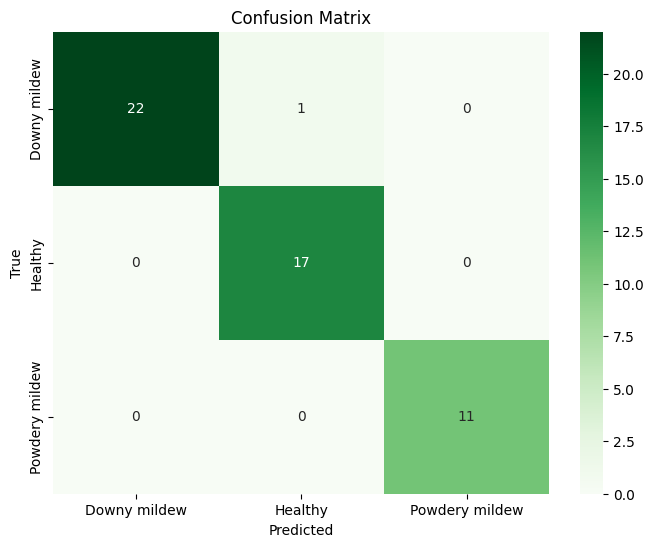

In [15]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Class names of my outputs
class_names = ["Downy mildew", "Healthy", "Powdery mildew"]

#Function to get predictions and true labels for confusion matrix

def get_predictions(model, test_loader):
    true_labels = []
    pred_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())  # Moving labels to CPU for plotting
            pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

# Get predictions from the test set
true_labels, pred_labels = get_predictions(model, test_loader)

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
